For each point in the data set, we run through the KG classification.  This requires

Tann - Annual mean temperature

Tmax - Highest monthly mean temperature

Tmin - Lowest monthly mean temperature

Pann - Accumulated annual precipitation

Pmin - Accumulated precipitation of driest month

Psmin - Lowest monthly summer precipitation

Psmax - Highest monthly summer precipitation

Pwmin - Lowest monthly winter precipitation

Pwmax - Highest monthly winter precipitation

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
import matplotlib.pyplot as plt
import math
import matplotlib.colors as color

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [3]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [4]:
#Bring in the whole dataset
start = time.time()
#ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
ds = xr.open_mfdataset('D:/Programing/LANL_summer/LOCA/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

6.710015296936035


# Functions to Prepare Data

spring (March, April, May), summer (June, July, August), autumn (September, October, November) and winter (December, January, February)

In [5]:
def monthly_mean(ds):
    '''
    Finds the average value for a given month for a data set.  For example, given 20 years of data, month 1 corresponds to the mean
    of each of the 20 January values.
    
    Note that the dates on these correspond to the first year rather than the whole time interval.  This is to ensure that datetime
    functions later work.
    '''
    #First, we find date index to be added back into our data array
    year_min = pd.DatetimeIndex(ds.time.values).year.min()
    date = pd.to_datetime("{}-01-16".format(year_min))
    time_index = date + pd.to_timedelta(np.arange(12), 'M')
    
    #Next, we take the mean along each month:
    ds = ds.groupby('time.month').mean('time')
    ds = ds.assign_coords(month = time_index)

    

    return ds

In [6]:
def build_rolling_mean(ds, delta_t):
    '''
    This function takes a data set ds and a time chunk delta_t and uses these to build a new data set of rolling averages along
    the months
    '''
    
    #First, compute how many years we will have
    year_min = pd.DatetimeIndex(ds.time.values).year.min()
    year_max = pd.DatetimeIndex(ds.time.values).year.max()
    number_years = year_max -year_min - delta_t+1
    
    #Compute the first monthly mean
    ds2 = ds.isel(time=slice(0,12*delta_t))
    ds2 = monthly_mean(ds2)
    
    #For each delta_t year span, compute the average
    for t in range(1, number_years):
        dst = ds.isel(time=slice(12*t,12*delta_t + 12*t))
        dst = monthly_mean(dst)
        ds2 = xr.concat([ds2,dst], dim = 'month')
        
    return ds2

In [7]:
dst = build_rolling_mean(ds, 25)

In [8]:
dst

<xarray.Dataset>
Dimensions:  (lat: 614, lon: 928, month: 468)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.8 -124.8 -124.7 -124.7 -124.6 ...
  * lat      (lat) float64 14.66 14.72 14.78 14.84 14.91 14.97 15.03 15.09 ...
  * month    (month) datetime64[ns] 1950-01-16 1950-02-15T10:29:06 ...
Data variables:
    Prec     (month, lat, lon) float32 dask.array<shape=(468, 614, 928), chunksize=(1, 614, 928)>
    Tmax     (month, lat, lon) float32 dask.array<shape=(468, 614, 928), chunksize=(1, 614, 928)>
    Tmin     (month, lat, lon) float32 dask.array<shape=(468, 614, 928), chunksize=(1, 614, 928)>
    wind     (month, lat, lon) float32 dask.array<shape=(468, 614, 928), chunksize=(1, 614, 928)>

In [9]:
#Functions used to select summer and winter half of years
def is_sum(month):
    return (month >= 4) & (month <= 9)

def is_win(month):
    return (month<=3) | (month >=10)

In [10]:
#Select the summmer and winter half of years
dst_summer = dst.sel(month=is_sum(dst['month.month']))
dst_winter = dst.sel(month=is_win(dst['month.month']))

In [11]:
#Compute the means, max, etc of the xarray data
dst_mean = dst.mean(dim='month')
dst_max = dst.max(dim='month')
dst_min = dst.min(dim='month')
dst_acc = dst.sum(dim='month')

dst_summer_max = dst_summer.max(dim='month')
dst_summer_min = dst_summer.min(dim = 'month')
dst_summer_sum = dst_summer.sum(dim='month')

dst_winter_max = dst_winter.max(dim='month')
dst_winter_min = dst_winter.max(dim='month')
dst_winter_sum = dst_winter.sum(dim='month')

In [12]:
#Convert the xarray data types above into np arrays as needed for biome functions:

#Year long Tmax, Tmin, Prec min and Prec accumulation
T_max = np.array(dst_max.Tmax)
P_ann = np.array(dst_acc.Prec)
T_min = np.array(dst_min.Tmin)
P_min = np.array(dst_min.Prec)

#Total Prec in summer and winter
P_s_sum = np.array(dst_summer_sum.Prec)
P_w_sum = np.array(dst_winter_sum.Prec)

#Min and max of Prec in summer and winter
P_s_min = np.array(dst_summer_min.Prec)
P_w_min = np.array(dst_winter_min.Prec)
P_w_max = np.array(dst_winter_max.Prec)
P_s_max = np.array(dst_summer_max.Prec)

T_mean = 0.5*(T_max + T_min)

C:\Users\Derek\Miniconda3\lib\site-packages\dask\array\numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\Derek\Miniconda3\lib\site-packages\dask\compatibility.py:48: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
C:\Users\Derek\Miniconda3\lib\site-packages\toolz\functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [13]:
def pth_build(Tmean, Pann, Pwsum, Pssum):
    '''
    Given the mean temperature, winter and summer precipitation, compute P_th
    '''
    #Find two thirds of the annual precip
    twothirds = (2/3)*Pann
    
    #Create the winter mask
    winter_mask = twothirds-Pwsum
    winter_mask[winter_mask>0] = 0
    winter_mask[winter_mask<0] = 1
    
    #Create the summer mask
    summer_mask = twothirds-Pssum
    summer_mask[summer_mask>0]=0
    summer_mask[summer_mask<0] = 1
    
    #Remainder mask - note that this will include the location of nan values since those experience zero precip
    else_mask = np.ones_like(Tmean) - winter_mask - summer_mask
    
    #Create Pth
    pth_win = 2*Tmean*winter_mask
    pth_sum = 2*Tmean*summer_mask + 28*summer_mask
    pth_else = 2*Tmean*else_mask + 14*else_mask
    
    pth = pth_win + pth_sum + pth_else
    
    return pth

In [14]:
Pth = pth_build(T_mean, P_ann, P_w_sum, P_s_sum)

In [15]:
Pth.shape

(614, 928)

In [16]:
def warm_summer_mask(ds):
    '''
    This function finds the mask for the warm summer climates in the sub-sub-classes of C and D
    '''
    #First, we find the monthly mean temperature for our data set
    monthly_mean = ds.groupby('month.month').mean('month')
    temp_mean = (0.5)*(monthly_mean.Tmax + monthly_mean.Tmin)
    temp_mean = np.array(temp_mean)
    
    #Now we create the mask:
    warmsum = np.copy(temp_mean)
    warmsum = np.nan_to_num(warmsum)
    warmsum[temp_mean<10] = 0
    warmsum[temp_mean>=10] = 1
    warmsum = np.sum(warmsum, axis=0)
    
    return warmsum

In [17]:
warmsum = warm_summer_mask(dst)

C:\Users\Derek\Miniconda3\lib\site-packages\dask\array\numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


# Class Functions

In [18]:
def ET_loc(Tmax):
    '''
    Takes Tmax as numpy array to return the locations of ET.
    '''
    ET = np.zeros_like(Tmax)
    ET[(0<=Tmax) & (Tmax<10)] = 1
    
    return ET

In [19]:
def EF_loc(Tmax):
    '''
    Takes Tmax as numpy array to return the locations of EF.
    '''
    EF = np.zeros_like(Tmax)
    EF[Tmax<0] = 1
    
    return EF

In [20]:
def BS_loc(Pann, Pth):
    '''
    Takes Pann and Pth as np arrays to return the locations of BS.
    '''
    BS = np.zeros_like(Pann)
    BS[(5*Pth < Pann) & (Pann < 10*Pth)]=1
    
    return BS

In [21]:
def BW_loc(Pann, Pth):
    '''
    Takes Pann and Pth as np arrays to return the locations of BW.
    '''
    BW = np.zeros_like(Pann)
    BW[(5*Pth >= Pann)]=1
    
    return BW

In [22]:
def AF_loc(Tmin, Pmin, BE):
    '''
    Takes Tmin and Pmin to as np arrays to return the locations of AF.
    '''
    
    AF = np.zeros_like(Tmin)
    
    #First, select all the possible locations of interest in the A class:
    AF[Tmin>=18] = 1
    #Then, remove locations not in the AF class:
    AF[Pmin<60] = 0
    #Then remove classes B and E:
    AF = AF - BE
    AF[AF<0] = 0
    
    return AF

In [23]:
def AM_loc(Tmin, Pann, Pmin, BE):
    '''
    
    '''
    
    AM = np.zeros_like(Tmin)
    #First, select all the possible locations of interest in the A class:
    AM[Tmin>=18] = 1
    #Then, remove locations not in the AM class:
    AM[Pann<25*(100-Pmin)]=0
    #Then remove classes B and E:
    AM = AM - BE
    AM[AM<0] = 0
    
    
    return AM

In [24]:
def AS_loc(Tmin, Pssum, BE):
    '''
    Takes Tmin and Pmin to as np arrays to return the locations of AS.
    '''   
    
    AS = np.zeros_like(Tmin)
    #First, select all the possible locations of interest in the A class:
    AS[Tmin>=18] = 1
    #Then, remove locations not in the AS class:
    AS[Pssum>=60] = 0
    #Then remove classes B and E:
    AS = AS - BE
    AS[AS<0] = 0
    
    return AS

In [25]:
def AW_loc(Tmin, Pwsum, BE):
    '''
    Takes Tmin and Pmin to as np arrays to return the locations of AW.
    '''   
    
    AW = np.zeros_like(Tmin)
    #First, select all the possible locations of interest in the A class:
    AW[Tmin>=18] = 1
    #Then, remove locations not in the AS class:
    AW[Pwsum>=60] = 0
    #Then remove classes B and E:
    AW = AW - BE
    AW[AW<0] = 0
    
    return AW

In [26]:
def CS_loc(Tmin, Psmin, Pwmin, Pwmax, BE):
    '''
    
    '''
    
    CS = np.zeros_like(Tmin)
    #First, select all possible locations of interest in the C class:
    CS[(-3< Tmin) & (Tmin<18)] = 1
    #Then remove locations not in the CS class:
    CS[Psmin>=Pwmin] = 0
    CS[Pwmax<=3*Psmin] = 0
    CS[Psmin>=40] = 0
    #Then remove classes B and E:
    CS = CS - BE
    CS[CS<0] = 0
    
    return CS

In [27]:
def CW_loc(Tmin, Psmin, Pwmin, Psmax, BE):
    '''
    
    '''
    
    CW = np.zeros_like(Tmin)
    #First, select all possible locations of interest in the C class:
    CW[(-3< Tmin) & (Tmin<18)] = 1
    #Then remove locations not in the CW class:
    CW[Pwmin>=Psmin] = 0
    CW[Psmax<= 10*Pwmin] = 0
    #Then remove classes B and E:
    CW = CW - BE
    CW[CW<0] = 0
    
    
    return CW

In [28]:
def CF_loc(Tmin, CS, CW, BE):
    '''
    
    '''
    CF = np.zeros_like(Tmin)
    #First, select all possible locations of interest in the C class:
    CF[(-3< Tmin) & (Tmin<18)] = 1
    #Remove everything in the CS and CW class:
    CF = CF - CS - CW
    #Then remove classes B and E:
    CF = CF - BE
    CF[CF<0] = 0
    
    
    return CF

In [29]:
def DS_loc(Tmin, Psmin, Pwmin, Pwmax, BE):
    '''
    
    '''
    
    DS = np.zeros_like(Tmin)
    #First, select all possible locations of interest in the C class:
    DS[(-3>= Tmin)] = 1
    #Then remove locations not in the CS class:
    DS[Psmin>=Pwmin] = 0
    DS[Pwmax<=3*Psmin] = 0
    DS[Psmin>=40] = 0
    #Then remove classes B and E:
    DS = DS - BE
    DS[DS<0] = 0
    
    return DS

In [30]:
def DW_loc(Tmin, Psmin, Pwmin, Psmax, BE):
    '''
    
    '''
    
    DW = np.zeros_like(Tmin)
    #First, select all possible locations of interest in the C class:
    DW[(-3>=Tmin)] = 1
    #Then remove locations not in the CW class:
    DW[Pwmin>=Psmin] = 0
    DW[Psmax<= 10*Pwmin] = 0
    #Then remove classes B and E:
    DW = DW - BE
    DW[DW<0] = 0
    
    return DW

In [31]:
def DF_loc(Tmin, DS, DW, BE):
    '''
    
    '''
    DF = np.zeros_like(Tmin)
    #First, select all possible locations of interest in the C class:
    DF[(-3>= Tmin)] = 1
    #Remove everything in the CS and CW class:
    DF = DF - DS - DW
    #Then remove classes B and E:
    DF = DF - BE
    DF[DF<0] = 0
    
    
    return DF

### The following are for finding the sub-sub classes of B-D

In [32]:
def B_sub(B_class, Tmean):
    '''
    This function finds the sub-sub classes within the B sub-classes.
    '''
    #First, we mask out the B subclass on the temperature:
    T_mask = B_class*Tmean
    
    #Next, we create a mask for the two sub-sub-classes:
    h_class = np.zeros_like(T_mask)
    h_class[T_mask>= 18] = 1
    
    k_class = B_class - h_class
    
    return h_class, k_class

In [33]:
def CD_sub(CD_class, Tmax, Tmin, warmsum):
    '''
    Compute sub-sub-classes of the C and D class
    '''
    
    #First, we compute the a class:
    T_max_mask = CD_class*Tmax
    a_class = np.zeros_like(Tmax)
    a_class[T_max_mask>= 22] = 1
    
    #Next we form the b class.  This is done by first selecting all possible points that might be in b_class, and then zeroing out the 
    #points that are not in b_class:
    b_class = CD_class - a_class
    b_class[warmsum<=3] = 0
    
    #Next, we form the c class in the same manor as b class:
    c_class = CD_class - a_class - b_class
    c_class[Tmin>=-38] = 0
    
    #What is left over is d_class
    d_class = CD_class - a_class - b_class - c_class
    
    return a_class, b_class, c_class, d_class

# Put together to compute class

In [92]:
def KG_model(Tmean, Tmax, Tmin, Pth, Pann, Pmin, Pssum, Pwsum, Psmin, Pwmin, Psmax, Pwmax, warmsum):
    '''
    Computes each of the KG classes
    '''
    
    ET = ET_loc(Tmax)
    EF = EF_loc(Tmax)
    
    BS = BS_loc(Pann, Pth)
    BW = BW_loc(Pann, Pth)
    
    #Add together to get BE, which is used to compute the rest of the classes
    BE = ET+EF+BS+BW
    
    AF = AF_loc(Tmin, Pmin, BE)
    AM = AM_loc(Tmin, Pann, Pmin, BE)
    AS = AS_loc(Tmin, Pssum, BE )
    AW = AW_loc(Tmin, Pwsum, BE)
    
    CS = CS_loc(Tmin, Psmin, Pwmin, Pwmax, BE)
    CW = CW_loc(Tmin, Psmin, Pwmin, Psmax, BE)
    CF = CF_loc(Tmin, CS, CW, BE)
    
    DS = DS_loc(Tmin, Psmin, Pwmin, Pwmax, BE)
    DW = DW_loc(Tmin, Psmin, Pwmin, Psmax, BE)
    DF = DF_loc(Tmin, DS, DW, BE)
    
    #Find the sub-classes of B:
    BSh, BSk =  B_sub(BS, Tmean)
    BWs, BWk =  B_sub(BW, Tmean)
    
    #Find the sub classes of C:  Note that CSd is not possible by construction
    CSa, CSb, CSc, CSd = CD_sub(CS, Tmax, Tmin, warmsum)
    CWa, CWb, CWc, CWd = CD_sub(CW, Tmax, Tmin, warmsum)
    CFa, CFb, CFc, CFd = CD_sub(CF, Tmax, Tmin, warmsum)
    
    #Find the sub classes of D:
    DSa, DSb, DSc, DSd = CD_sub(DS, Tmax, Tmin, warmsum)
    DWa, DWb, DWc, DWd = CD_sub(DW, Tmax, Tmin, warmsum)
    DFa, DFb, DFc, DFd = CD_sub(DF, Tmax, Tmin, warmsum)
    
    
#     KGA = AF + AM + AS + AW
#     KGB = BS + BW
#     KGC = CS + CW + CF
#     KGD = DS + DW + DF
#     KGE = ET + EF
    
    KG = ET + 2*EF + 3*BSh + 4*BSk + 5*BWs + 6*BWk + 7*CSa + 8*CSb + 9*CSc + 10*CWa + 11*CWb + 12*CWc + 13*CFa + 14*CFb + 15*CFc +16*DSa + 17*DSb + 18*DSc +  19*DSd + 20*DWa +21*DWb + 22*DWc + 23*DWd + 24*DFa + 25*DFb + 26*DFc +  27*DFd +  28*AF + 29*AM + 30*AS + 31*AW
    
    #KG = ET + 2*EF + 3*BS + 4*BW + 5*AF + 6*AM + 7*AS + 8*AW + 9*CS + 10*CW + 11*CF + 12*DS + 13*DW + 14*DF 
    return KG

In [93]:
KG = KG_model(T_mean, T_max, T_min, Pth, P_ann, P_min, P_s_sum, P_w_sum, P_s_min, P_w_min, P_s_max, P_w_max, warmsum)

C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Derek\Miniconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encounte

### All Class

In [101]:
np.histogram(KG, bins=29)

(array([236755,      1,      0,   9061,  32036,   5891,   1320,  31915,   1045,      0,      0,      0,      0,  34950,     76,      0,  31273,    566,      0,   6021,      0,      0,      0,      0, 166232,    420,      0,  12182,     48], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

lat_space = np.linspace(start = np.min(ds.lat.data), stop = np.max(ds.lat.data), num = 7)
lat_space = np.round(lat_space, decimals = 1)
lon_space = np.linspace(start = np.min(ds.lon.data), stop = np.max(ds.lon.data), num = 7)
lon_space = np.round(lon_space, decimals = 1)

In [102]:
colormap = np.array([
    [255, 255, 255],
    [255, 204, 255],
    [204, 255, 255],
    [255, 153, 51],
    [255, 102, 0],
    [204, 102, 0],
    [255, 51, 0],
    [255, 255, 0],
    [204, 153, 0],
    [204, 204, 0],
    [153, 255, 51],
    [153, 204, 0],
    [102, 255, 51],
    [102, 153, 0],
    [0, 153, 0],
    [0, 255, 0],
    [0, 255, 153],
    [51, 153, 102],
    [51, 204, 204],
    [0, 102, 153],
    [0, 51, 102],
    [0, 153, 255],
    [0, 51, 153],
    [0, 0, 255],
    [0, 0, 204],
    [0, 0, 102],
    [102, 102, 255],
    [51, 51, 204],
    [102, 0, 51],
    [204, 102, 153],
    [153, 0, 153],
    [204, 51, 153],
])

In [103]:
colormap = (1/255)*colormap

In [104]:
cmaprand = color.ListedColormap(colormap)

In [105]:
plot_labels = ['ET', 'EF' ,'BSh', 'BSk','BWs','BWk','CSa','CSb','CSc','CWa','CWb','CWc' ,'CFa','CFb','CFc','DSa','DSb','DSc','DSd','DWa','DWb','DWc','DWd','DFa','DFb','DFc','DFd','AF','AM','AS','AW']

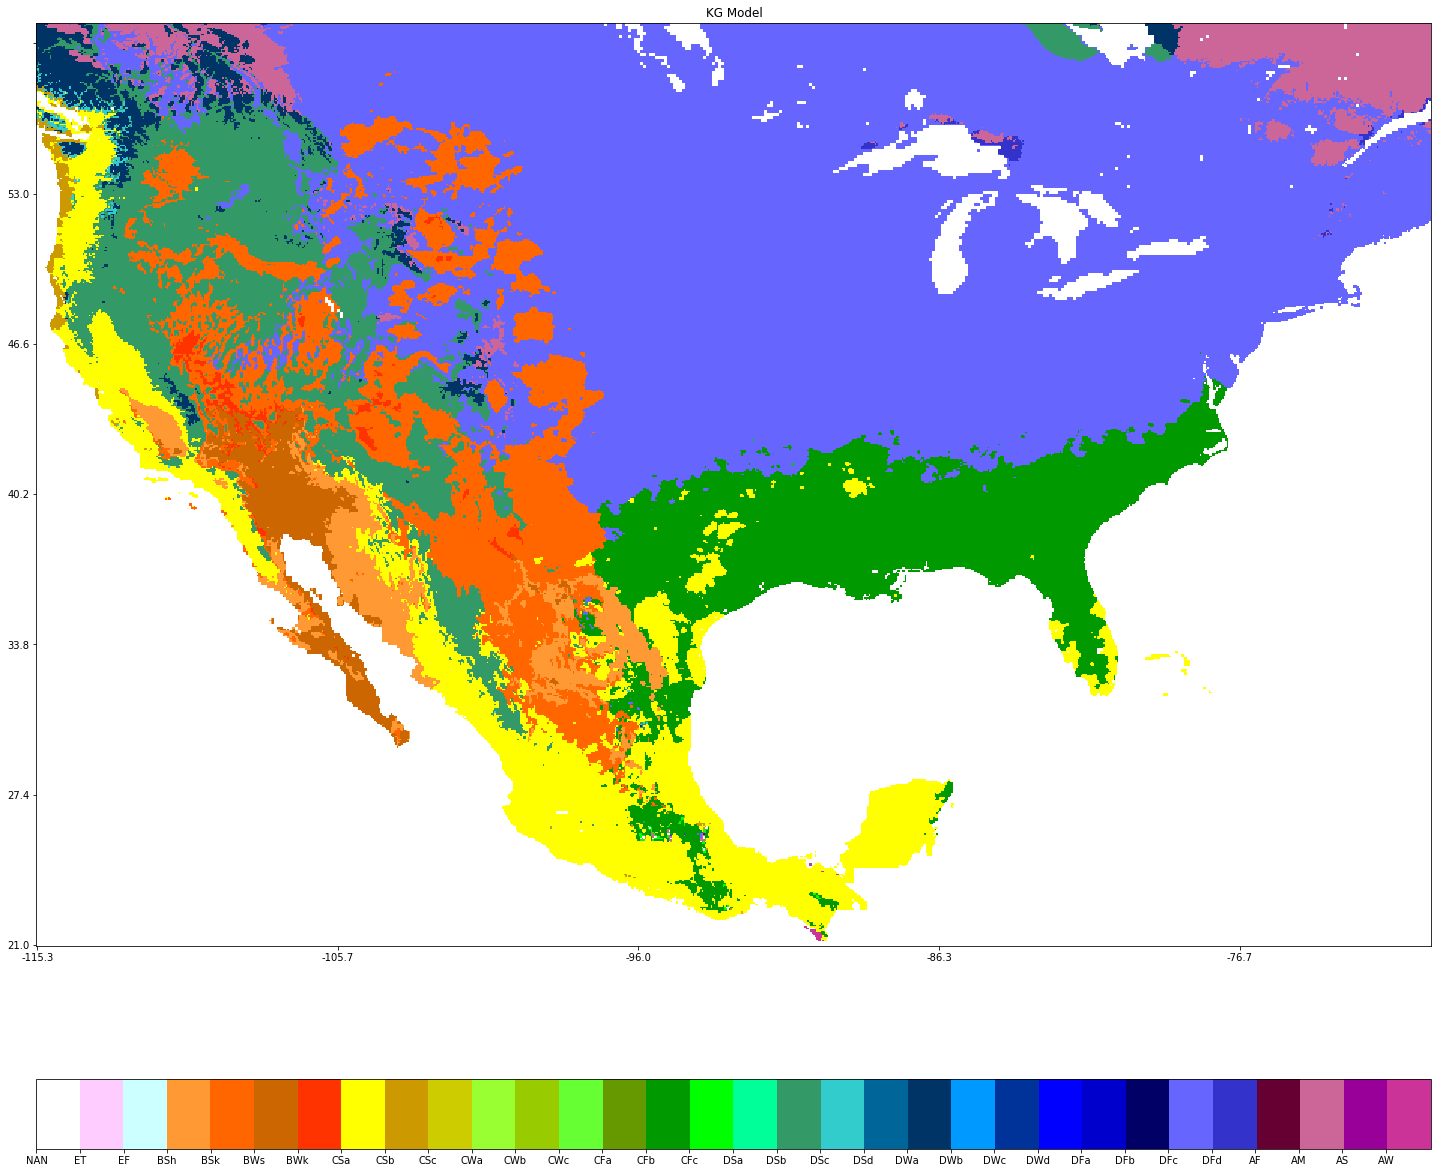

In [109]:
f, ax = plt.subplots(figsize=(25, 35), ncols=1, nrows=1)
    #Plot Prec
p0 = plt.imshow(KG, cmap=cmaprand, origin = [0,0])
#p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])

cbar = f.colorbar(p0, ax=ax, orientation='horizontal', ticks= np.arange(0,32*.905, .905),
             pad=0.07, fraction=0.05)

#cbar.ax.set_xticks([p0.colorbar.vmin + t*(p0.colorbar.vmax-p0.colorbar.vmin) for t in cbar.ax.get_xticks()])
#cbar.set_ticks([p0.colorbar.vmin + t*(p0.colorbar.vmax - p0.colorbar.vmin) for t in cbar.ax.get_xticks()])
cbar.ax.set_xticklabels(['NAN','ET', 'EF' ,'BSh', 'BSk','BWs','BWk','CSa','CSb','CSc','CWa','CWb','CWc' ,'CFa','CFb','CFc','DSa','DSb','DSc','DSd','DWa','DWb','DWc','DWd','DFa','DFb','DFc','DFd','AF','AM','AS','AW'])

#Title and labels for edges of figure
ax.set_title('KG Model') 
ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()